In [1]:
import joblib
import os

# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Processed Dataset / Trained Model / Processes
Will load any completed processes, datasets, trained model in the case of Kernel Crash

In [2]:
X_train_scaled_loaded = joblib.load('../../00_dataset/with_stopwords/data/X_train_scaled.joblib')
X_test_scaled_loaded = joblib.load('../../00_dataset/with_stopwords/data/X_test_scaled.joblib')
X_val_scaled_loaded = joblib.load('../../00_dataset/with_stopwords/data/X_val_scaled.joblib')

y_train_loaded = joblib.load('../../00_dataset/with_stopwords/data/y_train.joblib')
y_test_loaded = joblib.load('../../00_dataset/with_stopwords/data/y_test.joblib')
y_val_loaded = joblib.load('../../00_dataset/with_stopwords/data/y_val.joblib')

X_train_smote_loaded = joblib.load('../../00_dataset/with_stopwords/data/X_train_smote.joblib')
y_train_smote_loaded = joblib.load('../../00_dataset/with_stopwords/data/y_train_smote.joblib')

In [3]:
print(X_train_scaled_loaded.index.equals(y_train_loaded.index))
print(X_test_scaled_loaded.index.equals(y_test_loaded.index))
print(X_val_scaled_loaded.index.equals(y_val_loaded.index))
print(X_train_smote_loaded.index.equals(y_train_smote_loaded.index))

True
True
True
True


In [5]:
lr_saga_scaled_loaded = joblib.load('../../00_dataset/with_stopwords/model/lr_saga_scaled.joblib')
svm_linear_scaled_loaded = joblib.load('../../00_dataset/with_stopwords/model/svm_linear_scaled.joblib')

lr_saga_smote_loaded = joblib.load('../../00_dataset/with_stopwords/model/lr_saga_smote.joblib')
svm_linear_smote_loaded = joblib.load('../../00_dataset/with_stopwords/model/svm_linear_smote.joblib')

# Loading Datasets
Dataset that have gone through pre-processing and feature enginnering

In [6]:
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type != 'category':
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Reduced by {(start_mem - end_mem) / start_mem:.1%}')

    return df

In [11]:
chunk_size = 100000
chunks_train = pd.read_csv("../../00_dataset/with_stopwords/train_features_sw.csv", chunksize=chunk_size, low_memory=False)
chunks_test = pd.read_csv("../../00_dataset/with_stopwords/test_features_sw.csv", chunksize=chunk_size, low_memory=False)
chunks_val = pd.read_csv("../../00_dataset/with_stopwords/val_features_sw.csv", chunksize=chunk_size, low_memory=False)

df_trainChunks = [reduce_memory(chunk_train) for chunk_train in chunks_train]
df_train = pd.concat(df_trainChunks, axis=0)

df_testChunks = [reduce_memory(chunk_test) for chunk_test in chunks_test]
df_test = pd.concat(df_testChunks, axis=0)

df_valChunks = [reduce_memory(chunk_val) for chunk_val in chunks_val]
df_val = pd.concat(df_valChunks, axis=0)

Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.73 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 990.75 MB
Memory usage after optimization: 495.00 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 829.14 MB
Memory usage after optimization: 414.24 MB
Reduced by 50.0%
Initial memory usage: 2325.73 MB
Memory usage after optimization: 1161.94 MB
Reduced by 50.0%


In [12]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.211111,0.9548,126,0,0,0.018395,59,0,3.753968,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.152564,0.9647,83,1,0,0.020151,35,0,3.795181,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.147253,0.7906,66,0,0,0.020761,29,0,3.393939,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.320036,0.9910,166,8,0,0.054917,86,0,3.722892,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300000,0.8832,83,0,0,0.029777,41,0,3.867470,0


In [13]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.211111,0.9548,126,0,0,0.018395,59,0,3.753968,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.152564,0.9647,83,1,0,0.020151,35,0,3.795181,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.147253,0.7906,66,0,0,0.020761,29,0,3.393939,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.320036,0.9910,166,8,0,0.054917,86,0,3.722892,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300000,0.8832,83,0,0,0.029777,41,0,3.867470,0


In [14]:
df_val.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065255,0.9925,252,2,0,0.026408,146,0,3.511905,0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150000,0.6360,29,1,0,0.033333,5,0,3.172414,0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200000,0.9432,62,0,0,0.020478,34,0,3.741935,0
3,0.072918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.221902,0.9968,311,1,0,0.012221,214,0,3.475884,0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.123810,-0.3400,67,0,0,0.019868,29,0,3.522388,1


In [15]:
train_nan_counts = df_train.isna().sum()
print("NaN values in train set:\n", train_nan_counts[train_nan_counts > 0])
test_nan_counts = df_test.isna().sum()
print("NaN values in test set:\n", test_nan_counts[test_nan_counts > 0])
val_nan_counts = df_val.isna().sum()
print("NaN values in test set:\n", val_nan_counts[val_nan_counts > 0])

NaN values in train set:
 Series([], dtype: int64)
NaN values in test set:
 Series([], dtype: int64)
NaN values in test set:
 Series([], dtype: int64)


# Splitting Dataset

In [16]:
# Separate into X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

X_val = df_val.drop(columns=["label"])
y_val = df_val["label"]

In [17]:
# Check class distribution after split
print("Train Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation Class Distribution:\n", y_val.value_counts(normalize=True))
print("\nTest Class Distribution:\n", y_test.value_counts(normalize=True))

Train Class Distribution:
 label
0    0.867799
1    0.132201
Name: proportion, dtype: float64

Validation Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64

Test Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64


# Feature Scaling

In [ ]:
# Feature Scaling
ct_mms = ColumnTransformer(transformers=[('min_max_scaler', MinMaxScaler(), ['sentiment_score', 'vader_score', 'review_length', 'exclamation_count', 'question_count', 'uppercase_ratio', 'duplicate_word_count', 'emoji_count', 'avg_word_length'])], remainder='passthrough')
X_train_scaled = ct_mms.fit_transform(X_train)
X_test_scaled = ct_mms.transform(X_test)
X_val_scaled = ct_mms.transform(X_val)

In [ ]:
feature_names = ct_mms.get_feature_names_out()

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index )
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_names, index=X_val.index)

In [ ]:
# Save scaled DataFrames
joblib.dump(X_train_scaled_df, '00_dataset/with_stopwords/data/X_train_scaled.joblib')
joblib.dump(X_test_scaled_df, '00_dataset/with_stopwords/data/X_test_scaled.joblib')
joblib.dump(X_val_scaled_df, '00_dataset/with_stopwords/data/X_val_scaled.joblib')

joblib.dump(y_train, '00_dataset/with_stopwords/data/y_train.joblib')
joblib.dump(y_test, '00_dataset/with_stopwords/data/y_test.joblib')
joblib.dump(y_val, '00_dataset/with_stopwords/data/y_val.joblib')

# Save the ColumnTransformer object for future transformations
joblib.dump(ct_mms, '00_dataset/with_stopwords/process/column_transformer.joblib')

In [ ]:
print("Training DataFrame:")
print(X_train.shape)
print(X_train_scaled.shape)

print("Testing DataFrame:")
print(X_test.shape)
print(X_test_scaled.shape)

print("Validatign DataFrame:")
print(X_val.shape)
print(X_val_scaled.shape)

# Model Training with Scaled Training Dataset

In [ ]:
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42)

lr.fit(X_train_scaled, y_train)

In [ ]:
joblib.dump(lr, '00_dataset/with_stopwords/model/lr_saga_scaled.joblib')

In [ ]:
svm = SVC(class_weight='balanced', kernel='linear', max_iter=1000, random_state=42)

svm.fit(X_train_scaled, y_train)

In [ ]:
joblib.dump(svm, '00_dataset/with_stopwords/model/svm_linear_scaled.joblib')

In [ ]:
nb = MultinomialNB(class_prior=[0.5, 0.5])
nb.fit(X_train_scaled_loaded, y_train_loaded)

# Apply Smote

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_loaded, y_train_loaded)

In [ ]:
# Save smote DataFrames
joblib.dump(X_train_smote, '00_dataset/with_stopwords/data/X_train_smote.joblib')
joblib.dump(y_train_smote, '00_dataset/with_stopwords/data/y_train_smote.joblib')

# Model Training with Smoted Dataset

In [ ]:
lr_smote = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42)

lr_smote.fit(X_train_smote, y_train_smote)

In [ ]:
joblib.dump(lr_smote, '00_dataset/with_stopwords/model/lr_saga_smote.joblib')

In [ ]:
svm_smote = SVC(class_weight='balanced', kernel='linear', max_iter=1000, random_state=42)

svm_smote.fit(X_train_smote, y_train_smote)

In [ ]:
joblib.dump(lr_smote, '00_dataset/with_stopwords/model/svm_linear_smote.joblib')

In [7]:
# Set batch size
batch_size = 10000  # Adjust based on memory

# Initialize the Naïve Bayes model
nb_smote = MultinomialNB(class_prior=[0.5, 0.5])

# Train in batches using partial_fit
classes = np.unique(y_train_smote_loaded)  # Get all class labels
for i in range(0, len(X_train_smote_loaded), batch_size):
    X_batch = X_train_smote_loaded[i:i+batch_size]
    y_batch = y_train_smote_loaded[i:i+batch_size]
    
    if i == 0:
        # First batch: specify classes
        nb_smote.partial_fit(X_batch, y_batch, classes=classes)
    else:
        nb_smote.partial_fit(X_batch, y_batch)

# Evaluate Models
All models will be evaluated using the same the matrix. 

- Computes and displays performance metrics including accuracy, classification report, and confusion matrix.

- Computes ROC AUC scores if the model supports probability estimates (predict_proba) or decision function values (decision_function).

In [7]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a model's performance and display the confusion matrix, ROC AUC for both classes, and overall ROC AUC.
    Handles cases where predict_proba is not available.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Check if predict_proba is available
    if hasattr(model, "predict_proba"):
        # Get predicted probabilities for both classes
        y_proba = model.predict_proba(X_test)

        # Calculate ROC AUC for both classes
        roc_auc_class_0 = roc_auc_score(y_test, y_proba[:, 0])  # ROC AUC for class 0
        roc_auc_class_1 = roc_auc_score(y_test, y_proba[:, 1])  # ROC AUC for class 1
        roc_auc_overall = roc_auc_score(y_test, y_proba[:, 1])  # Overall ROC AUC

        print("ROC AUC for Class 0:", roc_auc_class_0)
        print("ROC AUC for Class 1:", roc_auc_class_1)
        print("Overall ROC AUC:", roc_auc_overall)

    elif hasattr(model, "decision_function"):
        # Use decision scores if predict_proba is not available
        decision_scores = model.decision_function(X_test)
        roc_auc_overall = roc_auc_score(y_test, decision_scores)
        print("ROC AUC (using decision scores):", roc_auc_overall)

    else:
        # If neither predict_proba nor decision_function is available
        print("ROC AUC cannot be calculated because the model does not support predict_proba or decision_function.")

/Users/hanwei23/Documents/GitHub/INF2008_YelpZip/path/to/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy: 0.6820333300463465
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.68      0.79     52802
           1       0.24      0.67      0.36      8044

    accuracy                           0.68     60846
   macro avg       0.59      0.68      0.57     60846
weighted avg       0.84      0.68      0.73     60846



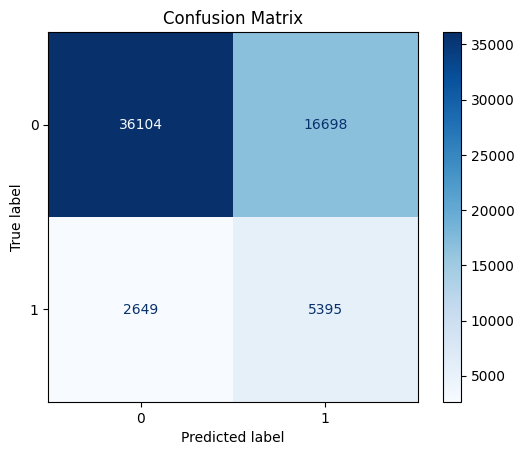

ROC AUC for Class 0: 0.2593188459646333
ROC AUC for Class 1: 0.7406811540353667
Overall ROC AUC: 0.7406811540353667


/Users/hanwei23/Documents/GitHub/INF2008_YelpZip/path/to/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [8]:
evaluate_model(lr_saga_scaled_loaded, X_val_scaled_loaded, y_val_loaded)

Accuracy: 0.768415343654472
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86     52802
           1       0.27      0.45      0.34      8044

    accuracy                           0.77     60846
   macro avg       0.59      0.63      0.60     60846
weighted avg       0.82      0.77      0.79     60846



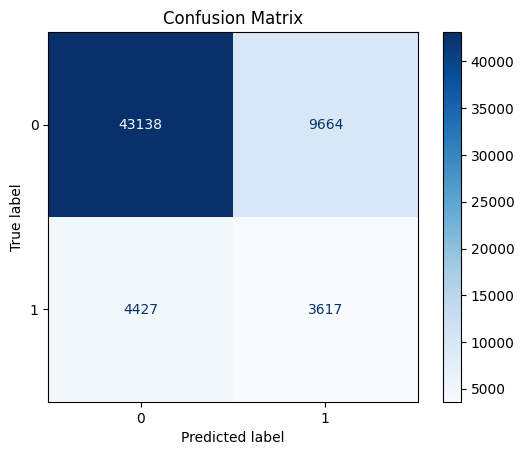

ROC AUC for Class 0: 0.2856000490823444
ROC AUC for Class 1: 0.7143999532720411
Overall ROC AUC: 0.7143999532720411


In [9]:
evaluate_model(lr_saga_smote_loaded, X_val_scaled_loaded, y_val_loaded)

/Users/hanwei23/Documents/GitHub/INF2008_YelpZip/path/to/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy: 0.13221904480163035
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     52802
           1       0.13      1.00      0.23      8044

    accuracy                           0.13     60846
   macro avg       0.57      0.50      0.12     60846
weighted avg       0.89      0.13      0.03     60846



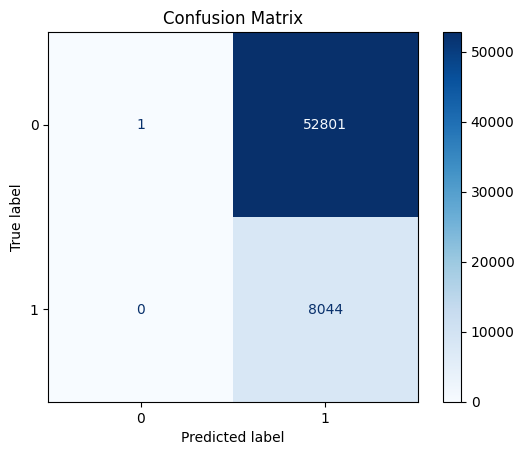

/Users/hanwei23/Documents/GitHub/INF2008_YelpZip/path/to/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


ROC AUC (using decision scores): 0.5736157376616406


In [10]:
evaluate_model(svm_linear_scaled_loaded, X_val_scaled_loaded, y_val_loaded)

Accuracy: 0.768415343654472
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86     52802
           1       0.27      0.45      0.34      8044

    accuracy                           0.77     60846
   macro avg       0.59      0.63      0.60     60846
weighted avg       0.82      0.77      0.79     60846



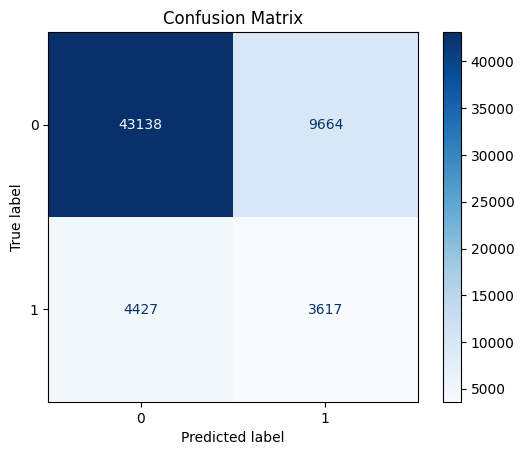

ROC AUC for Class 0: 0.2856000490823444
ROC AUC for Class 1: 0.7143999532720411
Overall ROC AUC: 0.7143999532720411


In [11]:
evaluate_model(svm_linear_smote_loaded, X_val_scaled_loaded, y_val_loaded)

In [ ]:
evaluate_model(nb, X_val_scaled_loaded, y_val_loaded)

Accuracy: 0.689790618939618
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.80     52802
           1       0.24      0.62      0.34      8044

    accuracy                           0.69     60846
   macro avg       0.58      0.66      0.57     60846
weighted avg       0.83      0.69      0.74     60846



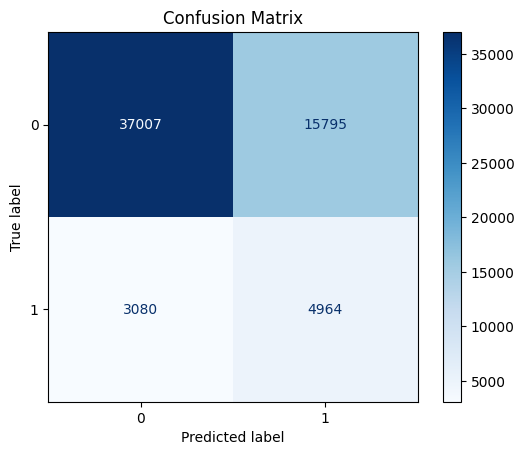

ROC AUC for Class 0: 0.280343180779641
ROC AUC for Class 1: 0.719656819220359
Overall ROC AUC: 0.719656819220359


In [10]:
evaluate_model(nb_smote, X_val_scaled_loaded, y_val_loaded)